In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
! pip install nibabel
import nibabel as nib
import numpy as np
import os, glob
import psutil
import gc
import pandas as pd
import zipfile
import os, glob, gzip, csv
import numpy as np
import nibabel as nib
import os, glob, gzip
from nibabel.filebasedimages import ImageFileError
from scipy.ndimage import gaussian_filter, binary_fill_holes
from numpy.linalg import svd, det
from nibabel.processing import resample_from_to
from io import BytesIO


mpl.rcParams.update({
    "font.family": "Liberation Sans",   # or "Liberation Sans"
    "pdf.fonttype": 42,             # Embed TrueType fonts
    "ps.fonttype": 42,              # Prevent outline fonts
    "text.usetex": False,
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "savefig.dpi": 300
})

In [2]:
# changes directory from colab to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Choose your base folder (local runtime or Drive)
BASE_DIR = "/content/drive/MyDrive/Capstone-Project/figures"

# Create it if it doesn't exist
os.makedirs(BASE_DIR, exist_ok=True)

print(f"Figures will be saved to: {BASE_DIR}")

Figures will be saved to: /content/drive/MyDrive/Capstone-Project/figures


# Compile all Images

In [4]:
# Root(s) that contain your NFBS and PP images
roots = [
    "/content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset"
    #"/content/drive/MyDrive/Capstone-Project/data/nfbs-data/PP_Images/mask"#,  # adjust or remove if not needed
]

# Pattern(s) for files you want (edit to be precise)
patterns = [
    "**/*_brainmask.nii.gz"    # NFBS brain masks
    #"**/*_mask_pp.nii.gz"       # PP masks (example)
    # add more patterns if needed
]

def list_files(roots, patterns, limit=None):
    files = []
    for root in roots:
        for pat in patterns:
            files.extend(glob.glob(os.path.join(root, pat), recursive=True))
    files = sorted(set(files))
    return files[:limit] if limit else files

def load_volumes(filepaths, as_float32=True, mmap=True, check_shape=True):
    vols = []
    shape0 = None
    for fp in filepaths:
        img = nib.load(fp, mmap=mmap)
        data = img.get_fdata()  # float64 default
        if as_float32:
            data = data.astype(np.float32, copy=False)
        if check_shape:
            if shape0 is None:
                shape0 = data.shape
            else:
                if data.shape != shape0:
                    raise ValueError(f"Shape mismatch: {fp} has {data.shape}, expected {shape0}")
        vols.append(data)
    return vols

In [5]:
# 1) Collect files
filepaths = list_files(roots, patterns, limit=None)
print(f"Found {len(filepaths)} files")
for fp in filepaths[:5]:
    print("  ", fp)

# 2) Load them all
volumes = load_volumes(filepaths)

# 3) Flatten each and stack → result shape = (n_files, n_voxels)
result = np.vstack([v.ravel() for v in volumes])
print("result shape:", result.shape)

Found 125 files
   /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz
   /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00028352/sub-A00028352_ses-NFB3_T1w_brainmask.nii.gz
   /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00032875/sub-A00032875_ses-NFB3_T1w_brainmask.nii.gz
   /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00033747/sub-A00033747_ses-NFB3_T1w_brainmask.nii.gz
   /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00034854/sub-A00034854_ses-NFB3_T1w_brainmask.nii.gz
result shape: (125, 12582912)


# Compile and Preprocess NBFS Brain image files

Recurses for *_T1w_brain.nii[.gz]

Skips empty/corrupt files

Crops to the tight nonzero bounding box (keeps geometry)

Z-scores intensities within brain

(Optional) mild smoothing (off by default)

Saves outputs and CSV logs

In [6]:
# ---------- file utils ----------
def list_files(roots, patterns, limit=None):
    files = []
    for root in roots:
        for pat in patterns:
            files += glob.glob(os.path.join(root, pat), recursive=True)
    files = sorted(set(files))
    return files[:limit] if limit else files

def is_nonempty_file(fp, min_bytes=512):
    try:
        return os.path.exists(fp) and os.path.getsize(fp) >= min_bytes
    except Exception:
        return False

def is_valid_gz(fp):
    if not fp.endswith(".gz"): return True
    try:
        with gzip.open(fp, "rb") as f: _ = f.read(1)
        return True
    except Exception:
        return False

def safe_load(fp, mmap=True):
    try:
        img = nib.load(fp, mmap=mmap)
        data = img.get_fdata(dtype=np.float32, caching='unchanged')
        if data.size == 0 or not np.any(np.isfinite(data)): return None, None
        return img, data
    except (ImageFileError, FileNotFoundError):
        return None, None
    except Exception:
        return None, None

# ---------- preprocess (anatomy branch only) ----------
def _nonzero_bbox(data, thresh=0.0):
    fg = np.any(data > thresh, axis=-1) if data.ndim == 4 else (data > thresh)
    if not np.any(fg):
        return (slice(0, data.shape[0]), slice(0, data.shape[1]), slice(0, data.shape[2]))
    coords = np.argwhere(fg)
    (x0,y0,z0),(x1,y1,z1) = coords.min(0), coords.max(0)
    pad=1
    x0=max(x0-pad,0); y0=max(y0-pad,0); z0=max(z0-pad,0)
    x1=min(x1+pad,data.shape[0]-1); y1=min(y1+pad,data.shape[1]-1); z1=min(z1+pad,data.shape[2]-1)
    return (slice(x0,x1+1), slice(y0,y1+1), slice(z0,z1+1))

def crop_img(img, data, bbox_slices):
    xsl, ysl, zsl = bbox_slices
    cropped = data[xsl, ysl, zsl, :] if data.ndim==4 else data[xsl, ysl, zsl]
    aff = img.affine.copy()
    start = np.array([xsl.start, ysl.start, zsl.start, 1.0], dtype=np.float32)
    new_aff = aff.copy(); new_aff[:3,3] = (aff @ start)[:3]
    return nib.Nifti1Image(cropped.astype(np.float32, copy=False), new_aff, header=img.header.copy())

def normalize_intensity(anat, brain_mask=None, method="zscore"):
    finite = np.isfinite(anat)
    if brain_mask is None:
        thr = np.percentile(anat[finite], 5)
        brain_mask = finite & (anat > thr)
        brain_mask = binary_fill_holes(brain_mask)
    x = anat[brain_mask]
    if x.size < 10: return anat
    if method == "zscore":
        mu, sd = float(np.mean(x)), float(np.std(x)+1e-8)
        return (anat - mu) / sd
    lo, hi = np.percentile(x, [1, 99]); scale = (hi-lo) if hi>lo else 1.0
    return (anat - lo) / scale

def save_img(img, out_path, like=None):
    to_write = img if like is None else nib.Nifti1Image(img.get_fdata(dtype=np.float32), img.affine, header=like.header.copy())
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    nib.save(to_write, out_path)

def preprocess_brain_anat(in_path, out_dir, do_crop=True, do_intensity_norm=True, do_smooth=False, smooth_sigma=0.5):
    img, data = safe_load(in_path, mmap=True)
    if img is None: raise ImageFileError("load_failed")
    img_c = crop_img(img, data, _nonzero_bbox(data, 0.0)) if do_crop else img
    arr = img_c.get_fdata(dtype=np.float32, caching='unchanged')
    if do_intensity_norm:
        arr = normalize_intensity(arr, brain_mask=None, method="zscore")
    if do_smooth:
        arr = gaussian_filter(arr, sigma=float(smooth_sigma))
    out_fp = os.path.join(out_dir, os.path.basename(in_path).replace(".nii.gz","_preproc.nii.gz").replace(".nii","_preproc.nii"))
    save_img(nib.Nifti1Image(arr, img_c.affine, header=img_c.header), out_fp, like=img_c)
    return out_fp, {"type":"anat","cropped":bool(do_crop),"intensity_norm":bool(do_intensity_norm),"smoothed":bool(do_smooth)}

In [7]:
# ---------- run with YOUR patterns ----------
roots    = ["/content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset"]
patterns = ["**/*_T1w_brain.nii.gz", "**/*_T1w_brain.nii"]  # your skull-stripped brains

files = list_files(roots, patterns)
print(f"Found {len(files)} candidates")
files = [fp for fp in files if is_nonempty_file(fp) and is_valid_gz(fp)]
print(f"After size/gz check: {len(files)} files")

out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_preproc_anat"
os.makedirs(out_dir, exist_ok=True)

results, skipped = [], []
for fp in files:
    try:
        out_fp, meta = preprocess_brain_anat(
            fp, out_dir,
            do_crop=True,
            do_intensity_norm=False,  # yes for brains
            do_smooth=False          # set True if you want mild smoothing
        )
        results.append({"input": fp, "output": out_fp, **meta})
    except Exception as e:
        skipped.append({"input": fp, "reason": e.__class__.__name__})

print(f"Done. Kept: {len(results)} | Skipped: {len(skipped)}")

# ---------- logs ----------
log_dir = os.path.join(out_dir, "_logs"); os.makedirs(log_dir, exist_ok=True)
with open(os.path.join(log_dir, "preproc_results.csv"), "w", newline="") as f:
    import csv
    cols = sorted({k for d in results for k in d.keys()}) if results else ["input","output","type","cropped","intensity_norm","smoothed"]
    w = csv.DictWriter(f, fieldnames=cols); w.writeheader()
    for r in results: w.writerow(r)
with open(os.path.join(log_dir, "preproc_skipped.csv"), "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["input","reason"]); w.writeheader()
    for r in skipped: w.writerow(r)

print("Logs saved in:", log_dir)


Found 125 candidates
After size/gz check: 124 files
Done. Kept: 124 | Skipped: 0
Logs saved in: /content/drive/MyDrive/Capstone-Project/derivatives/pp_preproc_anat/_logs


# Quality Check - Post Preprocessing

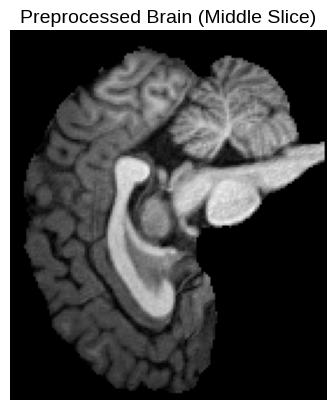

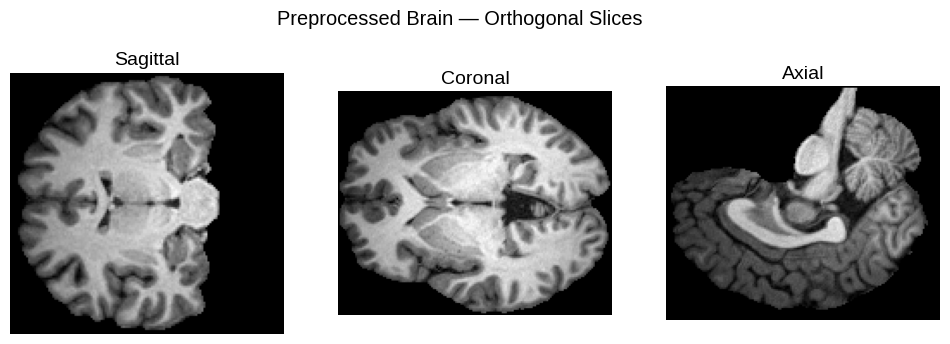

In [8]:
# Load one preprocessed file (e.g., the second one)
img = nib.load(results[1]["output"])
data = img.get_fdata()

# Display the middle axial slice
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray', origin='lower')
plt.axis('off')
plt.title("Preprocessed Brain (Middle Slice)")
save_path = os.path.join(BASE_DIR, "qc_middle_slice.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.show()


mid_x, mid_y, mid_z = [s // 2 for s in data.shape]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[2].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
for ax, title in zip(axes, ['Sagittal', 'Coronal', 'Axial']):
    ax.set_title(title); ax.axis('off')
plt.suptitle("Preprocessed Brain — Orthogonal Slices")
save_path = os.path.join(BASE_DIR, "qc_cor_sag_ax.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.show()


# Pick a Reference image and mask

In [9]:
# ---------- helpers ----------
def is_nonempty_file(fp, min_bytes=512):
    try:
        return os.path.exists(fp) and os.path.getsize(fp) >= min_bytes
    except Exception:
        return False

def is_valid_gz(fp):
    if not fp.endswith(".gz"):
        return True
    try:
        with gzip.open(fp, "rb") as f:
            _ = f.read(1)
        return True
    except Exception:
        return False

def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p) and is_nonempty_file(p) and is_valid_gz(p):
            return p
    return None

def glob_one(patterns):
    hits = []
    for pat in patterns:
        hits += glob.glob(pat, recursive=True)
    # prefer largest (often most complete) that is nonempty/valid
    hits = [h for h in hits if is_nonempty_file(h) and is_valid_gz(h)]
    if not hits:
        return None
    hits.sort(key=lambda p: os.path.getsize(p), reverse=True)
    return hits[0]

# ---------- main ----------
def find_reference(base="/content/drive/MyDrive/Capstone-Project"):
    # Paths
    tpl_dir   = os.path.join(base, "data/templates")
    nfbs_root = os.path.join(base, "data/nfbs-data/NFBS_Dataset")
    pp_root   = os.path.join(base, "data/nfbs-data/PP_Images")

    # 1) Your group template (preferred if you made one)
    group_img  = os.path.join(tpl_dir, "group_mean_T1.nii.gz")
    group_mask = os.path.join(tpl_dir, "group_mean_brainmask.nii.gz")
    if os.path.exists(group_img) and os.path.exists(group_mask) and \
       is_nonempty_file(group_img) and is_nonempty_file(group_mask):
        return group_img, group_mask, "Group template"

    # 2) NFBS skull-stripped brains first: *_T1w_brain + optional brainmask
    ss_img = glob_one([
        os.path.join(nfbs_root, "**/*_T1w_brain.nii.gz"),
        os.path.join(nfbs_root, "**/*_T1w_brain.nii"),
    ])
    if ss_img:
        # Try to find a matching brainmask for the same subject/session
        base_ss = os.path.basename(ss_img)
        stem = base_ss.replace("_T1w_brain.nii.gz", "").replace("_T1w_brain.nii", "")
        # common mask name variants
        candidate_masks = [
            os.path.join(nfbs_root, f"**/{stem}_brainmask.nii.gz"),
            os.path.join(nfbs_root, f"**/{stem}_brainmask.nii"),
            os.path.join(nfbs_root, f"**/{stem}_T1w_brainmask.nii.gz"),
            os.path.join(nfbs_root, f"**/{stem}_T1w_brainmask.nii"),
        ]
        ss_mask = glob_one(candidate_masks)
        # It is fine if mask is None (already skull-stripped)
        return ss_img, ss_mask, "NFBS skull-stripped T1w_brain"

    # 3) NFBS non-stripped T1w + separate brainmask
    nfbs_img  = glob_one([
        os.path.join(nfbs_root, "**/*_T1w.nii.gz"),
        os.path.join(nfbs_root, "**/*_T1w.nii"),
    ])
    nfbs_mask = glob_one([
        os.path.join(nfbs_root, "**/*brainmask.nii.gz"),
        os.path.join(nfbs_root, "**/*brainmask.nii"),
    ])
    if nfbs_img and nfbs_mask:
        return nfbs_img, nfbs_mask, "NFBS T1w + brainmask"

    # 4) Standard MNI (FSL installs)
    mni_img  = first_existing([
        "/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz",
        "/usr/share/fsl/data/standard/MNI152_T1_1mm.nii.gz",
        "/opt/fsl/data/standard/MNI152_T1_1mm.nii.gz",
    ])
    mni_mask = first_existing([
        "/usr/local/fsl/data/standard/MNI152_T1_1mm_brain_mask.nii.gz",
        "/usr/share/fsl/data/standard/MNI152_T1_1mm_brain_mask.nii.gz",
        "/opt/fsl/data/standard/MNI152_T1_1mm_brain_mask.nii.gz",
    ])
    if mni_img and mni_mask:
        return mni_img, mni_mask, "MNI152 (FSL)"

    # 5) PP mask-only template (mask workflows)
    pp_template_mask = os.path.join(pp_root, "template_mask_pp.nii.gz")
    if os.path.exists(pp_template_mask) and is_nonempty_file(pp_template_mask):
        return pp_template_mask, None, "PP mask-only template"

    # 6) Heuristic fallback anywhere under project
    any_img = glob_one([
        os.path.join(base, "**/*T1w_brain.nii.gz"),
        os.path.join(base, "**/*T1w_brain.nii"),
        os.path.join(base, "**/*T1*.nii.gz"),
        os.path.join(base, "**/*T1*.nii"),
        os.path.join(base, "**/*template*T1*.nii*"),
    ])
    any_mask = glob_one([
        os.path.join(base, "**/*brainmask*.nii.gz"),
        os.path.join(base, "**/*brainmask*.nii"),
        os.path.join(base, "**/*_mask*.nii*"),
    ])
    if any_img:
        return any_img, any_mask, "Heuristic match"

    # Nothing found
    return None, None, "Not found"


In [10]:
# ---- Example usage
ref_img_path, ref_mask_path, picked = find_reference(
    base="/content/drive/MyDrive/Capstone-Project"
)
print("Picked:", picked)
print("ref_img_path :", ref_img_path)
print("ref_mask_path:", ref_mask_path)


Picked: NFBS skull-stripped T1w_brain
ref_img_path : /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00050940/sub-A00050940_ses-NFB3_T1w_brain.nii.gz
ref_mask_path: /content/drive/MyDrive/Capstone-Project/data/nfbs-data/NFBS_Dataset/A00050940/sub-A00050940_ses-NFB3_T1w_brainmask.nii.gz


# Reference Image Registration & Feature Extraction

In [11]:
# ==============================================
# Register NFBS preprocessed brains to reference
# and extract features (global/intensity stats)
# Inputs: /derivatives/pp_preproc_anat/**/*_preproc.nii[.gz]
# Outputs: registered NIfTI + pp_features.csv
# ==============================================

# -----------------------------
# File helpers (robust)
# -----------------------------
def list_files(roots, patterns, limit=None):
    files = []
    for r in roots:
        for pat in patterns:
            files += glob.glob(os.path.join(r, pat), recursive=True)
    files = sorted(set(files))
    return files[:limit] if limit else files

def is_nonempty_file(fp, min_bytes=512):
    try:
        return os.path.exists(fp) and os.path.getsize(fp) >= min_bytes
    except Exception:
        return False

def is_valid_gz(fp):
    if not fp.endswith(".gz"):
        return True
    try:
        with gzip.open(fp, "rb") as f:
            _ = f.read(1)
        return True
    except Exception:
        return False

def safe_load(fp, mmap=True):
    try:
        img = nib.load(fp, mmap=mmap)
        arr = img.get_fdata(dtype=np.float32, caching='unchanged')
        if arr.size == 0 or not np.any(np.isfinite(arr)):
            return None, None
        return img, arr
    except (ImageFileError, FileNotFoundError):
        return None, None
    except Exception:
        return None, None

# -----------------------------
# Utilities
# -----------------------------
def voxel_sizes(aff):
    return np.sqrt((aff[:3, :3] ** 2).sum(axis=0))

def voxel_volume(aff):
    return abs(np.linalg.det(aff[:3, :3]))

def is_binary_mask(data, tol=1e-3):
    finite = np.isfinite(data)
    if not np.any(finite):
        return False
    vals = data[finite]
    vmin, vmax = vals.min(), vals.max()
    if vmax <= 1.0 + tol and vmin >= -tol:
        uniq = np.unique(np.round(vals, 3))
        return np.all(np.isin(uniq, [0.0, 1.0]))
    return False

def mask_from_image(arr):
    """Coarse brain mask from image: top-of-histogram heuristic."""
    finite = np.isfinite(arr)
    if not np.any(finite):
        return np.zeros_like(arr, dtype=bool)
    x = arr[finite]
    thr = np.percentile(x, 5)
    m = (arr > thr) & finite
    m = binary_fill_holes(m)
    return m

def world_points_from_mask(mask_bool, aff, sample_fraction=0.1, seed=0):
    idx = np.argwhere(mask_bool)
    if idx.size == 0:
        return np.zeros((0, 3))
    rng = np.random.default_rng(seed)
    n = max(1000, int(sample_fraction * len(idx)))
    take = rng.choice(len(idx), size=min(n, len(idx)), replace=False)
    vox = idx[take]
    homo = np.c_[vox, np.ones(len(vox))]
    world = (aff @ homo.T).T[:, :3]
    return world

def pca_frame(points):
    if len(points) < 3:
        C = points.mean(axis=0) if len(points) else np.zeros(3)
        U = np.eye(3)
        return C, U
    C = points.mean(axis=0)
    X = points - C
    U, _, _ = svd(np.cov(X.T))
    if det(U) < 0:
        U[:, 2] *= -1.0
    return C, U

def compose_rt_scale(C_src, U_src, C_ref, U_ref, scale=1.0):
    R = U_ref @ U_src.T
    S = np.diag([scale, scale, scale, 1.0])
    T1 = np.eye(4); T1[:3, 3] = -C_src
    T2 = np.eye(4); T2[:3, 3] =  C_ref
    R4 = np.eye(4); R4[:3, :3] = R
    W = T2 @ R4 @ S @ T1
    return W

def save_nii_like(data, affine, header_like, out_path, order='F'):
    img = nib.Nifti1Image(np.asarray(data, dtype=np.float32, order=order), affine, header=header_like.copy())
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    nib.save(img, out_path)
    return out_path

# -----------------------------
# Core: register to template and extract features
# -----------------------------
def register_and_extract(
    in_path,
    ref_img_path,
    out_dir,
    ref_mask_path=None,
    do_scale=True,
    order_anat=1
):
    """
    Aligns 'in_path' to the reference image grid via PCA+COM alignment in world space.
    - For masks: nearest-neighbor resampling
    - For anatomicals: linear resampling (order_anat)
    Returns dict of paths + features.
    """
    os.makedirs(out_dir, exist_ok=True)

    # robust load
    img, arr = safe_load(in_path, mmap=True)
    if img is None:
        raise ImageFileError("load_failed")

    is_mask = is_binary_mask(arr if arr.ndim == 3 else arr[..., 0])

    # Load reference (+ mask)
    ref_img = nib.load(ref_img_path)
    ref_aff = ref_img.affine

    if ref_mask_path is not None and os.path.exists(ref_mask_path):
        ref_mask = nib.load(ref_mask_path).get_fdata() > 0.5
    else:
        ref_mask = mask_from_image(ref_img.get_fdata(dtype=np.float32))

    # Build source mask
    if is_mask:
        src_mask = arr > 0.5
    else:
        src_mask = mask_from_image(arr)

    # Compute frames
    P_src = world_points_from_mask(src_mask, img.affine)
    P_ref = world_points_from_mask(ref_mask, ref_aff)
    C_src, U_src = pca_frame(P_src)
    C_ref, U_ref = pca_frame(P_ref)

    # Optional isotropic scale (match brain sizes)
    if do_scale:
        vol_src = src_mask.sum() * voxel_volume(img.affine)
        vol_ref = ref_mask.sum() * voxel_volume(ref_aff)
        s = (vol_ref / vol_src) ** (1.0 / 3.0) if vol_src > 0 else 1.0
    else:
        s = 1.0

    # Compose world transform, update affine
    W = compose_rt_scale(C_src, U_src, C_ref, U_ref, scale=s)
    A_prime = W @ img.affine
    moved = nib.Nifti1Image(arr, A_prime, header=img.header.copy())

    # Resample to reference grid
    if is_mask:
        reg = resample_from_to(moved, ref_img, order=0)    # nearest for masks
    else:
        reg = resample_from_to(moved, ref_img, order=order_anat)  # linear for anatomy

    # Save registered
    base = os.path.basename(in_path)
    stem = base.replace(".nii.gz", "").replace(".nii", "")
    out_reg = os.path.join(out_dir, f"{stem}_registered.nii.gz")
    nib.save(reg, out_reg)

    # Features
    reg_arr = reg.get_fdata(dtype=np.float32)
    ref_vox_vol = voxel_volume(ref_aff)

    feats = {
        "input_path": in_path,
        "registered_path": out_reg,
        "is_mask": bool(is_mask),
        "ref_voxel_volume_mm3": float(ref_vox_vol),
    }

    if is_mask:
        m = reg_arr > 0.5
        if m.any():
            coords = np.argwhere(m)
            bbox_size = (np.ptp(coords, axis=0) + 1).astype(int)
            com = list(np.average(coords, axis=0))
        else:
            bbox_size = np.array([0, 0, 0], dtype=int)
            com = [None, None, None]
        feats.update({
            "brain_voxels": int(m.sum()),
            "brain_volume_mm3": float(m.sum() * ref_vox_vol),
            "center_of_mass_vox": com,
            "bbox_size_vox": tuple(int(x) for x in bbox_size),
        })
    else:
        m = mask_from_image(reg_arr)
        if m.any():
            x = reg_arr[m]
            q = np.percentile(x, [1, 5, 25, 50, 75, 95, 99]).tolist()
            feats.update({
                "brain_voxels": int(m.sum()),
                "brain_volume_mm3": float(m.sum() * ref_vox_vol),
                "intensity_mean": float(np.mean(x)),
                "intensity_std": float(np.std(x)),
                "intensity_p01_p99": (q[0], q[-1]),
                "intensity_percentiles": q,
            })
        else:
            feats.update({
                "brain_voxels": 0,
                "brain_volume_mm3": 0.0,
                "intensity_mean": None,
                "intensity_std": None,
                "intensity_percentiles": None,
            })

    return feats

In [12]:
# -----------------------------
# Batch runner for **NFBS preprocessed brains**
# -----------------------------
# Use the outputs you created earlier:
#   /content/drive/.../derivatives/pp_preproc_anat/**/*_preproc.nii[.gz]
roots = ["/content/drive/MyDrive/Capstone-Project/derivatives/pp_preproc_anat"]
patterns = ["**/*_preproc.nii.gz", "**/*_preproc.nii"]

pp_files_all = list_files(roots, patterns)
# Filter out empties/corrupts
pp_files = [fp for fp in pp_files_all if is_nonempty_file(fp) and is_valid_gz(fp)]
print(f"Found {len(pp_files_all)} preprocs; using {len(pp_files)} valid files.")

# Make sure you already have these from your find_reference(...)
# ref_img_path, ref_mask_path, picked = find_reference(base="...")  # run earlier
assert 'ref_img_path' in globals() and ref_img_path, "Set ref_img_path before running."
# ref_mask_path can be None

out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_registered"
os.makedirs(out_dir, exist_ok=True)

features = []
skipped = []
for p in pp_files:
    try:
        feats = register_and_extract(
            p,
            ref_img_path=ref_img_path,
            out_dir=out_dir,
            ref_mask_path=ref_mask_path,   # may be None
            do_scale=True,
            order_anat=1
        )
        features.append(feats)
    except Exception as e:
        print(f"[skip] {e.__class__.__name__}: {p}")
        skipped.append({"input": p, "reason": e.__class__.__name__})

# Save features
df = pd.DataFrame(features)
csv_path = os.path.join(out_dir, "pp_features.csv")
os.makedirs(out_dir, exist_ok=True)
df.to_csv(csv_path, index=False)
print("Saved features CSV ->", csv_path)

# Save skipped log (optional)
if skipped:
    import csv
    log_path = os.path.join(out_dir, "pp_skipped.csv")
    with open(log_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["input", "reason"])
        w.writeheader()
        for r in skipped:
            w.writerow(r)
    print("Saved skipped log ->", log_path)


Found 124 preprocs; using 124 valid files.
Saved features CSV -> /content/drive/MyDrive/Capstone-Project/derivatives/pp_registered/pp_features.csv


Rows total: 124 | plotted: 124
       brain_volume_mm3  intensity_mean
count      1.240000e+02      124.000000
mean       1.870192e+06      218.174539
std        3.048034e+03       31.004725
min        1.859717e+06      149.623093
25%        1.867787e+06      197.125923
50%        1.870292e+06      215.364952
75%        1.872283e+06      240.896919
max        1.877520e+06      291.204865


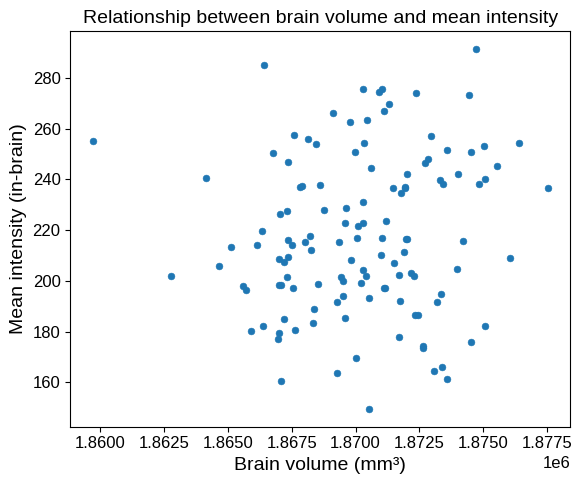

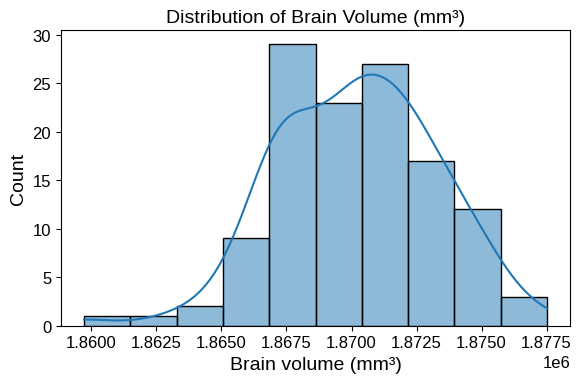

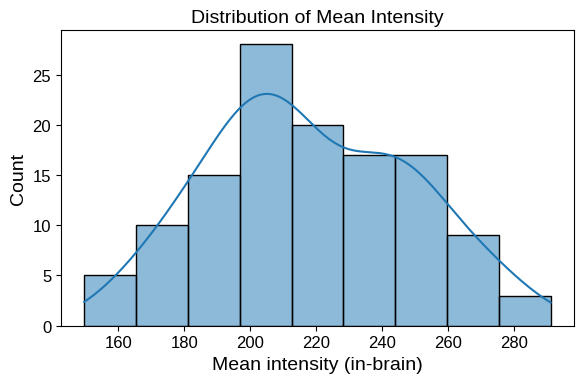

In [13]:
# If you don't already have df in memory, load it:
out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_registered"
df = pd.read_csv(os.path.join(out_dir, "pp_features.csv"))

# Keep only rows that have both volume and intensity (masks may have NaN intensity_mean)
df_plot = df.dropna(subset=["brain_volume_mm3", "intensity_mean"]).copy()

# Basic sanity prints
print("Rows total:", len(df), "| plotted:", len(df_plot))
print(df_plot[["brain_volume_mm3", "intensity_mean"]].describe())

# --- Scatter: volume vs intensity ---
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_plot, x="brain_volume_mm3", y="intensity_mean", s=24, edgecolor=None)
plt.title("Relationship between brain volume and mean intensity")
plt.xlabel("Brain volume (mm³)")
plt.ylabel("Mean intensity (in-brain)")
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "brain_vol_mean_intensity_scatter.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

# --- Histogram: brain volume ---
plt.figure(figsize=(6, 4))
sns.histplot(df_plot["brain_volume_mm3"], kde=True)
plt.title("Distribution of Brain Volume (mm³)")
plt.xlabel("Brain volume (mm³)")
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "brain_vol_hist.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

# --- Histogram: mean intensity ---
plt.figure(figsize=(6, 4))
sns.histplot(df_plot["intensity_mean"], kde=True)
plt.title("Distribution of Mean Intensity")
plt.xlabel("Mean intensity (in-brain)")
plt.tight_layout()
save_path = os.path.join(BASE_DIR, "hist_mean_intensity.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


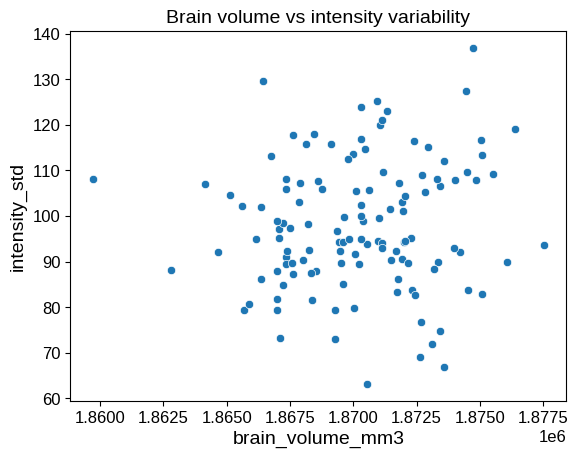

In [14]:
sns.scatterplot(data=df, x="brain_volume_mm3", y="intensity_std")
plt.title("Brain volume vs intensity variability")
# save_path = os.path.join(BASE_DIR, "brain_vol_intensity_variability.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


# To observe the gaussian distribution and perfect correlation between features, run the preprocessing step again with the below parameters-

            do_crop=True,
            do_intensity_norm=False,  # yes for brains
            do_smooth=False          # set True if you want mild smoothing